# Logistic regression model

In [1]:
# Standard library imports
from typing import Tuple

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# Random state
random_state=315

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)

total_disaster_months=len(data_df[data_df['incidents_binary'] != 0])
percent_disaster_months=(total_disaster_months/len(data_df)) * 100
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) disaster months\n')

data_df.info()

Have 1986(4.7%) disaster months

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41899 entries, (1955, 'AK', 1) to (2019, 'WY', 12)
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   incidents         41899 non-null  float64
 1   month_sin         41899 non-null  float64
 2   month_cos         41899 non-null  float64
 3   AL                41899 non-null  int64  
 4   AR                41899 non-null  int64  
 5   AS                41899 non-null  int64  
 6   AZ                41899 non-null  int64  
 7   CA                41899 non-null  int64  
 8   CO                41899 non-null  int64  
 9   CT                41899 non-null  int64  
 10  DC                41899 non-null  int64  
 11  DE                41899 non-null  int64  
 12  FL                41899 non-null  int64  
 13  FM                41899 non-null  int64  
 14  GA                41899 non-null  int64  
 15  GU                41899 non-n

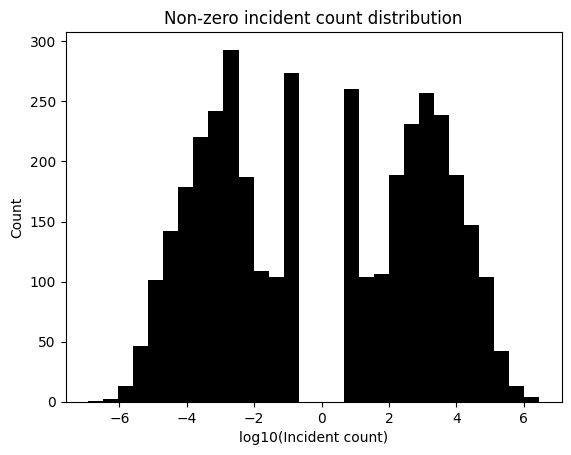

In [3]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Non-zero incident count distribution')
plt.hist(data_df['incidents'][data_df['incidents'] != 0], bins=30, color='black')
plt.xlabel('log10(Incident count)')
plt.ylabel('Count')
plt.show()

## 2. Data reshaping function

In [4]:
def generate_data(data_df: pd.DataFrame) -> Tuple[np.array, np.array]:
    '''Takes dataframe, parses data into feature label pairs where label
    is binarized incidents from the next month. Returns as tuple of numpy arrays'''

    # Get list of states
    states=data_df.index.get_level_values('state').unique().tolist()

    features=[]
    labels=[]

    # Loop on states
    for state in states:

        # Extract the data for this state
        state_df=data_df.loc[:,state,:]

        # Indexing variable for batch
        input_start_index=0

        # Loop on the state data
        while input_start_index + 1 < len(state_df):

            # Extract and collect the features
            features.append(state_df.iloc[input_start_index, :-1].values.tolist())

            # Extract and collect the labels
            labels.append(state_df.iloc[input_start_index + 1, -1])

            # Update the index
            input_start_index+=1

    return np.array(features), np.array(labels)

## 3. Train-test split

In [5]:
# Generate feature, label pairs
features, labels=generate_data(data_df)

In [6]:
# Split features and labels into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    random_state=random_state
)

Training features: (31380, 61)
Training labels: (31380,), 4.7% positive class
Testing features: (10460, 61)
Testing labels: (10460,), 4.8% positive class


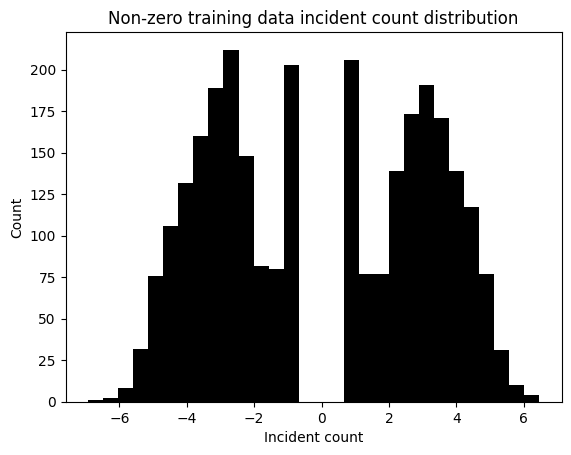

In [7]:
# Sanity check data shape and distribution
print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')

# Draw a quick plot to check the distribution of disaster counts
training_disaster_counts=training_features[:,0].flatten()
nonzero_training_disaster_counts=training_disaster_counts[np.nonzero(training_disaster_counts)]

plt.title('Non-zero training data incident count distribution')
plt.hist(nonzero_training_disaster_counts, bins=30, color='black')
plt.xlabel('Incident count')
plt.ylabel('Count')
plt.show()

## 4. Model fitting

In [8]:
model=LogisticRegression(
    class_weight='balanced',
    random_state=random_state,
    max_iter=10000
).fit(training_features, training_labels)

## 5. Model evaluation

Precision: 0.066
Recall: 0.687



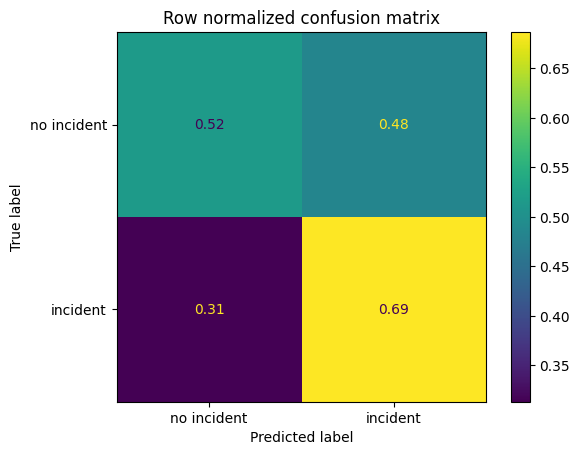

In [9]:
# Make predictions on the test set
predictions=model.predict(testing_features)

# Calculate precision and recall
precision=precision_score(testing_labels, predictions)
recall=recall_score(testing_labels, predictions)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(testing_labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no incident', 'incident'])
_=cm_disp.plot()
plt.title('Row normalized confusion matrix')
plt.show()